### **1. Requirement Gathering**
---

- **Problem:**
    - Melakukan kategori terhadap negara-negara yang diprioritaskan mendapatkan bantuan dari NGO.
- **Business Process:**
    - HELP International akan melakukan funding kepada negara-negara yang membutuhkan. Negara dikategorikan berdasarkan informasi socio-economic, kondisi maupun informasi lainnya mengenai negara tersebut
- **ML Model Type:** Unsupervised Learning
- **Output Type:** Categorical
- **Data Source:** JSON
- **Solution:** Untuk memprediksi apakah negara termasuk negara yang membutuhkan, kita bisa menggunakan beberapa cara
    - **ML Approach:**
        - Baseline model: 
        - Vanilla model: 
        - Multiple Model + Hyperparams
        - Using best model

- **Metrics:** Metrics yang digunakan untuk mengukur performa dari model ML yang dibuat akan menggunakan **Silhouette Score**

## **2. Data Pipeline**
---

In [4]:
import joblib
import yaml

In [5]:
def dump_joblib(data, path: str) -> None:
    joblib.dump(data, path)


def load_joblib(path: str):
    return joblib.load(path)

In [6]:
def load_params(param_dir):
    with open(param_dir, 'r') as file:
        params = yaml.safe_load(file)

    return params

In [7]:
params = load_params(param_dir = "config/params.yaml")

params

{'dataset_filename': 'country_data.csv',
 'dataset_dump_path': {'raw': 'data/raw/',
  'interim': 'data/interim/',
  'processed': 'data/processed/'},
 'int64_columns': ['income', 'gdpp'],
 'float64_columns': ['child_mort',
  'exports',
  'health',
  'imports',
  'inflation',
  'life_expec',
  'total_fer'],
 'object_columns': ['country'],
 'features': ['country',
  'child_mort',
  'exports',
  'health',
  'imports',
  'income',
  'inflation',
  'life_expec',
  'total_fer',
  'gdpp'],
 'model_dump_path': 'models/'}

In [8]:
import json
from sqlalchemy import create_engine, text as sql_text
from dotenv import load_dotenv
import os
import pandas as pd
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

load_dotenv()

False

#### **2.1 Data Ingestion**
---

In [9]:
file_path = 'country_data.json'

with open(file_path, 'r') as file:
    json_data = json.load(file)

df_country = pd.json_normalize(json_data['country_data'])

In [10]:
df_country

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200
...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310


In [11]:
dump_joblib(data = df_country, path = params["dataset_dump_path"]["raw"] + "raw_data.pkl")

#### **2.2 Data Definition**
---

- `country`: Name of the country
- `child_mort`: Death of children under 5 years of age per 1000 live births
- `exports`: Exports of goods and services per capita, given as a percentage of the GDP per capita
- `health`: Total health spending per capita, given as a percentage of the GDP per capita
- `imports`: Imports of goods and services per capita, given as a percentage of the GDP per capita
- `income`: Net income per person
- `inflation`: The measurement of the annual growth rate of the Total GDP
- `life_expec`: The average number of years a newborn child would live if the current mortality patterns remain the same
- `total_fer`: The number of children that would be born to each woman if the current age-fertility rates remain the same
- `gdpp`: The GDP per capita, calculated as the Total GDP divided by the total population

#### **2.3 Data Validation**
---

- Check data type
- Check data shape
- Check data distribution
- Check missing values

**Check Data Type**

In [12]:
df_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


**Check Data Shape**

In [13]:
print(f"Country Data have {df_country.shape[0]} rows and {df_country.shape[1]} columns")

Country Data have 167 rows and 10 columns


**Check Data Distribution**

In [14]:
df_country.describe().T

,count,mean,std,min,25%,50%,75%,max
child_mort,167.0,38.270060,40.328931,2.6000,8.250,19.30,62.10,208.00
exports,167.0,41.108976,27.412010,0.1090,23.800,35.00,51.35,200.00
health,167.0,6.815689,2.746837,1.8100,4.920,6.32,8.60,17.90
imports,167.0,46.890215,24.209589,0.0659,30.200,43.30,58.75,174.00
income,167.0,17144.688623,19278.067698,609.0000,3355.000,9960.00,22800.00,125000.00
inflation,167.0,7.781832,10.570704,-4.2100,1.810,5.39,10.75,104.00
life_expec,167.0,70.555689,8.893172,32.1000,65.300,73.10,76.80,82.80
total_fer,167.0,2.947964,1.513848,1.1500,1.795,2.41,3.88,7.49
gdpp,167.0,12964.155689,18328.704809,231.0000,1330.000,4660.00,14050.00,105000.00


**Check Missing Values**

In [15]:
df_country.isnull().sum()

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64

There are no missing values

**Check Duplicactes**

In [16]:
df_country.duplicated().sum()

np.int64(0)

and no duplicates

#### **2.4 Data Defense**
---

In [17]:
def data_defense_checker(input_data: pd.DataFrame, params: dict) -> None:
    try:
        print("===== Start Data Defense Checker =====")
        # check data types
        assert input_data[params["features"]].select_dtypes("object").columns.to_list() == params["object_columns"], "an error occurs in object columns"
        assert input_data[params["features"]].select_dtypes("int").columns.to_list() == params["int64_columns"], "an error occurs in integer columns"
        assert input_data[params["features"]].select_dtypes("float").columns.to_list() == params["float64_columns"], "an error occurs in integer columns"

    except Exception:
        raise Exception("Failed Data Defense Checker")

    finally:
        print("===== Finish Data Defense Checker =====")

In [18]:
data_defense_checker(input_data = df_country,
                     params = params)

===== Start Data Defense Checker =====
===== Finish Data Defense Checker =====


## **3. EDA (Exploratory Data Analysis)**
---

Text(0, 0.5, 'Density')

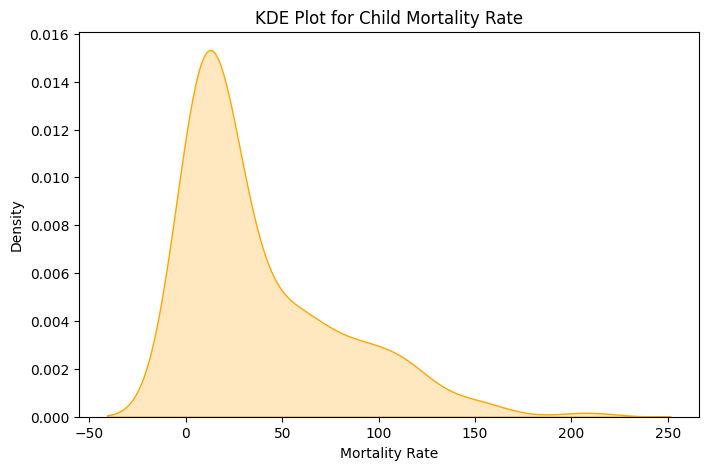

In [19]:
plt.figure(figsize=(8, 5))
sns.kdeplot(df_country['child_mort'], shade=True, color='orange')
plt.title('KDE Plot for Child Mortality Rate')
plt.xlabel('Mortality Rate')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

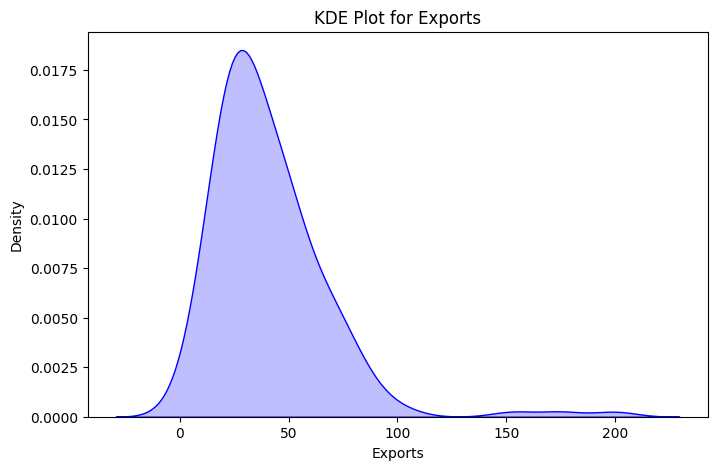

In [20]:
plt.figure(figsize=(8, 5))
sns.kdeplot(df_country['exports'], shade=True, color='blue')
plt.title('KDE Plot for Exports')
plt.xlabel('Exports')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

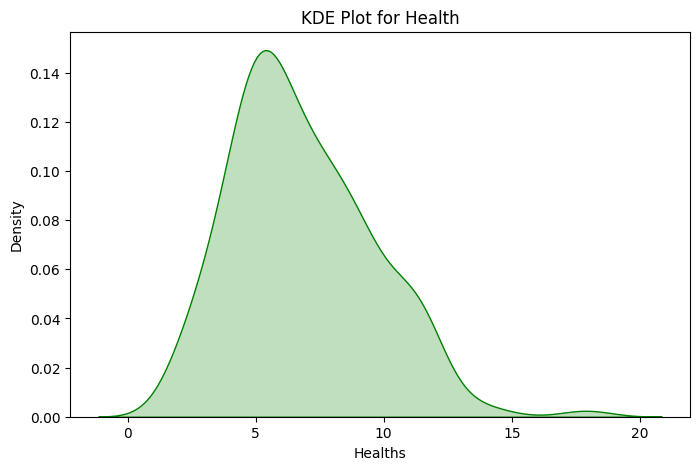

In [21]:
plt.figure(figsize=(8, 5))
sns.kdeplot(df_country['health'], shade=True, color='green')
plt.title('KDE Plot for Health')
plt.xlabel('Healths')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

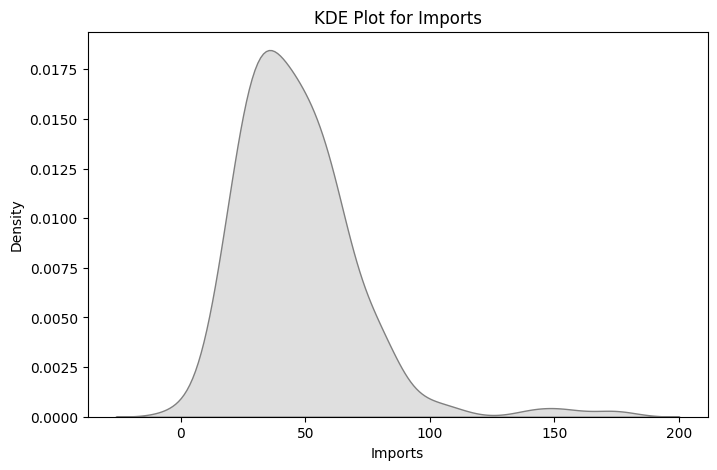

In [22]:
plt.figure(figsize=(8, 5))
sns.kdeplot(df_country['imports'], shade=True, color='gray')
plt.title('KDE Plot for Imports')
plt.xlabel('Imports')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

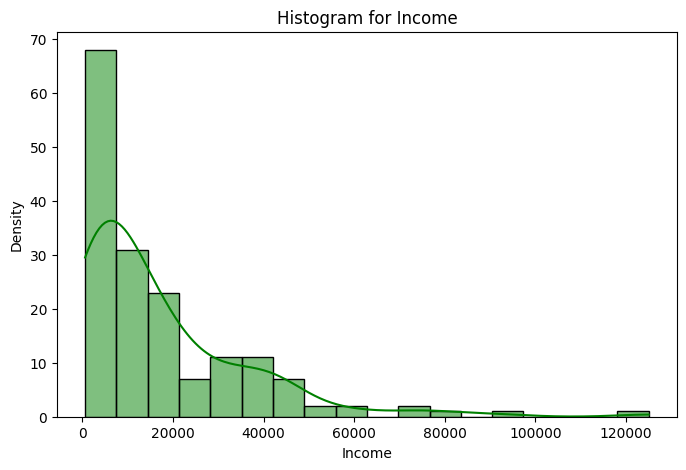

In [23]:
plt.figure(figsize=(8, 5))
sns.histplot(df_country['income'], kde=True, color='green')
plt.title('Histogram for Income')
plt.xlabel('Income')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

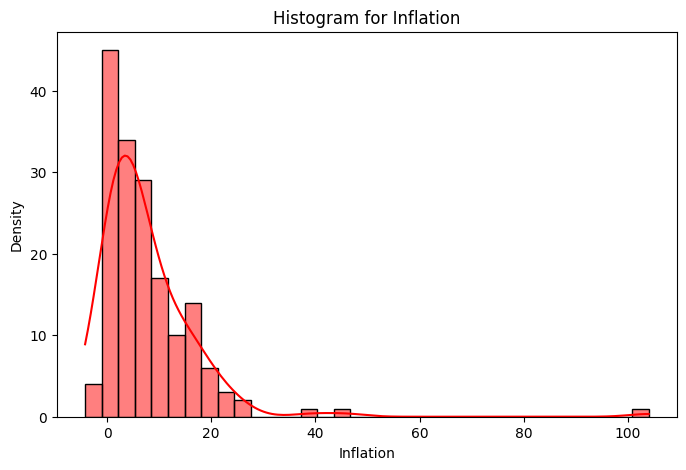

In [24]:
plt.figure(figsize=(8, 5))
sns.histplot(df_country['inflation'], kde=True, color='red')
plt.title('Histogram for Inflation')
plt.xlabel('Inflation')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

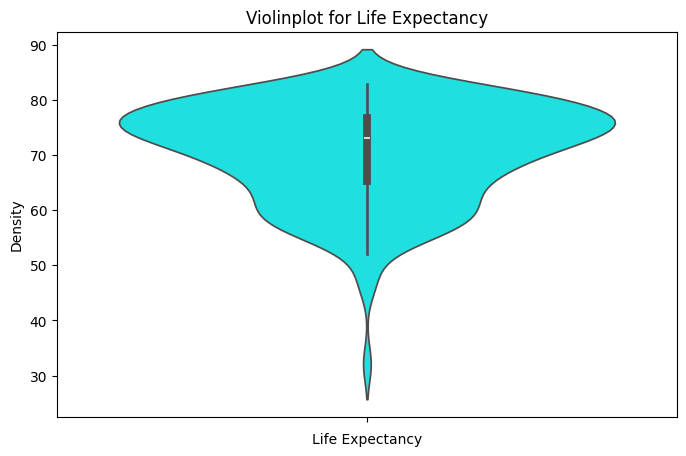

In [25]:
plt.figure(figsize=(8, 5))
sns.violinplot(y = df_country['life_expec'], color='cyan')
plt.title('Violinplot for Life Expectancy')
plt.xlabel('Life Expectancy')
plt.ylabel('Density')

Text(0, 0.5, 'Density')

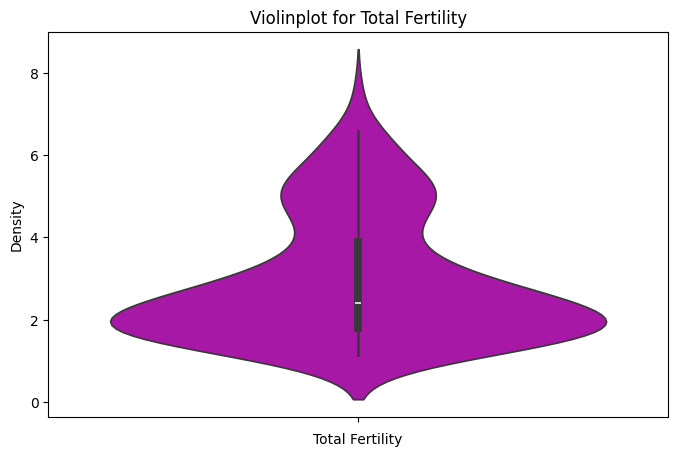

In [26]:
plt.figure(figsize=(8, 5))
sns.violinplot(y=df_country['total_fer'], color='m')
plt.title('Violinplot for Total Fertility')
plt.xlabel('Total Fertility')
plt.ylabel('Density')

Text(0.5, 0, 'GDPP')

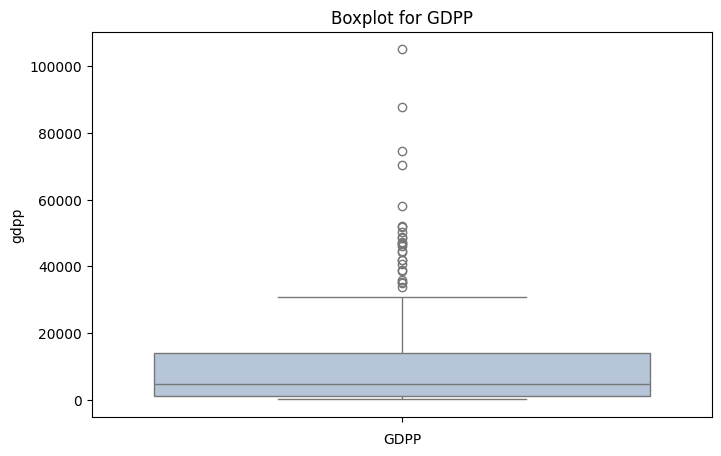

In [27]:
plt.figure(figsize=(8, 5))
sns.boxplot(df_country['gdpp'], color='lightsteelblue')
plt.title('Boxplot for GDPP')
plt.xlabel('GDPP')

<Axes: xlabel='income', ylabel='life_expec'>

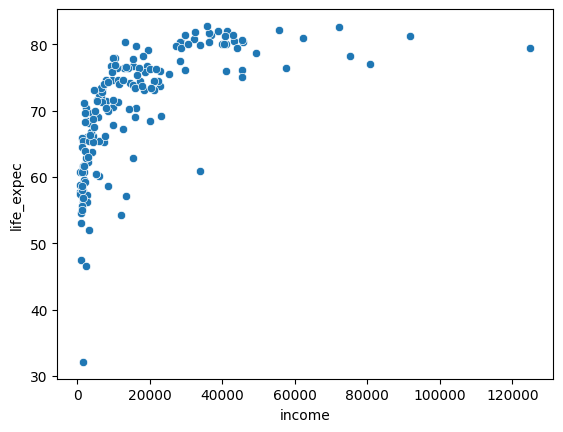

In [28]:
sns.scatterplot(x=df_country['income'], y=df_country['life_expec'])

<Axes: xlabel='income', ylabel='gdpp'>

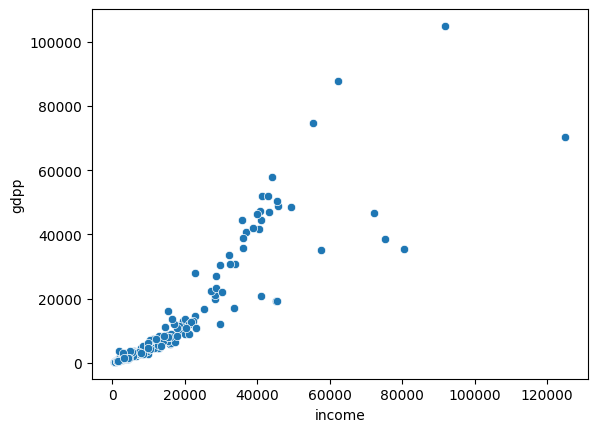

In [29]:
sns.scatterplot(x=df_country['income'], y=df_country['gdpp'])

<Axes: xlabel='income', ylabel='health'>

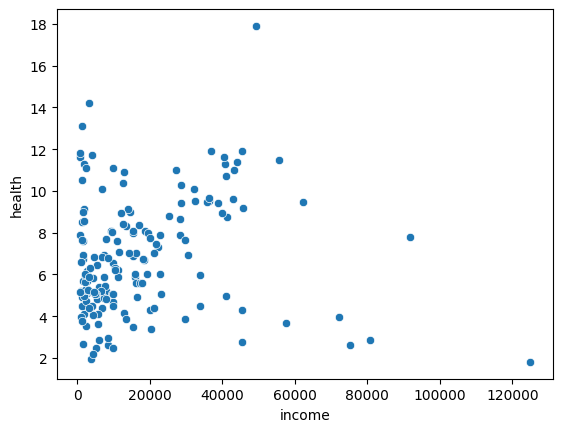

In [30]:
sns.scatterplot(x=df_country['income'], y=df_country['health'])

<Axes: xlabel='gdpp', ylabel='inflation'>

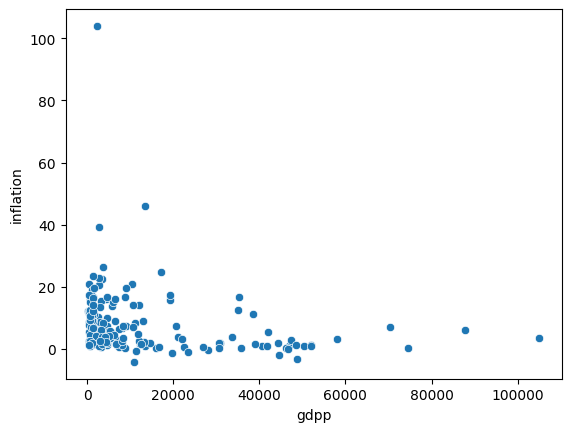

In [31]:
sns.scatterplot(x=df_country['gdpp'], y=df_country['inflation'])

In [32]:
import plotly.express as px 

fig = px.scatter(df_country, x="income", y="life_expec", 
                 size='child_mort',
                 color='child_mort')
  
fig.show()

In [33]:
import plotly.express as px 

fig = px.scatter(df_country, x="income", y="life_expec", 
                 size='total_fer',
                 color='total_fer')
  
fig.show()

## **4. Preprocessing & Feature Engineering**
---

### **4.1 Log Transformation, Feature Selection and Normalization**

In [34]:
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans

df_transformed = df_country.copy()

df_transformed['log_income'] = np.log1p(df_transformed['income'])
df_transformed['log_gdpp'] = np.log1p(df_transformed['gdpp'])

# Define and Apply StandardScaler and MinMaxScaler
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()
standard_features = ['child_mort', 'life_expec', 'log_income', 'log_gdpp']
minmax_features = ['exports', 'health', 'imports', 'inflation', 'total_fer']

df_transformed[standard_features] = standard_scaler.fit_transform(df_transformed[standard_features])
df_transformed[minmax_features] = minmax_scaler.fit_transform(df_transformed[minmax_features])

df_transformed = df_transformed.drop(columns=['income', 'gdpp'])
df_transformed

,country,child_mort,exports,health,imports,inflation,life_expec,total_fer,log_income,log_gdpp
0,Afghanistan,1.291532,0.049482,0.358608,0.257765,0.126144,-1.619092,0.736593,-1.413035,-1.460301
1,Albania,-0.538949,0.139531,0.294593,0.279037,0.080399,0.647866,0.078864,0.071660,-0.122835
2,Algeria,-0.272833,0.191559,0.146675,0.180149,0.187691,0.670423,0.274448,0.285240,-0.064916
3,Angola,2.007808,0.311125,0.064636,0.246266,0.245911,-1.179234,0.790221,-0.353257,-0.221309
4,Antigua and Barbuda,-0.695634,0.227079,0.262275,0.338255,0.052213,0.704258,0.154574,0.605586,0.608135
...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,-0.225578,0.232582,0.213797,0.302609,0.063118,-0.852161,0.370662,-0.918936,-0.336823
163,Venezuela,-0.526514,0.142032,0.192666,0.100809,0.463081,0.546361,0.208202,0.486145,0.675862
164,Vietnam,-0.372315,0.359651,0.312617,0.460715,0.150725,0.286958,0.126183,-0.576146,-0.884089
165,Yemen,0.448417,0.149536,0.209447,0.197397,0.257000,-0.344633,0.555205,-0.577965,-0.884089


In [35]:
# features = [col for col in df_transformed.columns if col != 'country']
# features_T = [f"{col}_T" for col in features]

df_scaled = df_transformed.iloc[:, 1:]

In [36]:
df_scaled

,child_mort,exports,health,imports,inflation,life_expec,total_fer,log_income,log_gdpp
0,1.291532,0.049482,0.358608,0.257765,0.126144,-1.619092,0.736593,-1.413035,-1.460301
1,-0.538949,0.139531,0.294593,0.279037,0.080399,0.647866,0.078864,0.071660,-0.122835
2,-0.272833,0.191559,0.146675,0.180149,0.187691,0.670423,0.274448,0.285240,-0.064916
3,2.007808,0.311125,0.064636,0.246266,0.245911,-1.179234,0.790221,-0.353257,-0.221309
4,-0.695634,0.227079,0.262275,0.338255,0.052213,0.704258,0.154574,0.605586,0.608135
...,...,...,...,...,...,...,...,...,...
162,-0.225578,0.232582,0.213797,0.302609,0.063118,-0.852161,0.370662,-0.918936,-0.336823
163,-0.526514,0.142032,0.192666,0.100809,0.463081,0.546361,0.208202,0.486145,0.675862
164,-0.372315,0.359651,0.312617,0.460715,0.150725,0.286958,0.126183,-0.576146,-0.884089
165,0.448417,0.149536,0.209447,0.197397,0.257000,-0.344633,0.555205,-0.577965,-0.884089


### **4.2 KMeans Clustering**
---

In [37]:
from sklearn.cluster import KMeans

def k_means_optimize(data, max_k):
    means = []
    inertias = []

    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(data)

        means.append(k)
        inertias.append(kmeans.inertia_)

    fig = plt.subplots(figsize=(10, 5))
    plt.plot(means, inertias, 'o-')
    plt.xlabel("Number of Clusters")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()

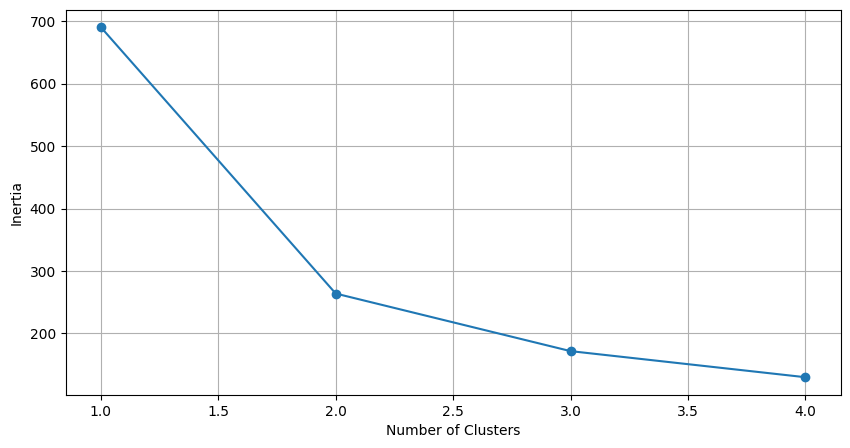

In [38]:
k_means_optimize(df_scaled, 5)

2 0.5314942439691723
3 0.4188986609584188
4 0.38281070547260354
5 0.35690409172888693
6 0.36938959162751633
7 0.37148528043992046
8 0.32072205324463826


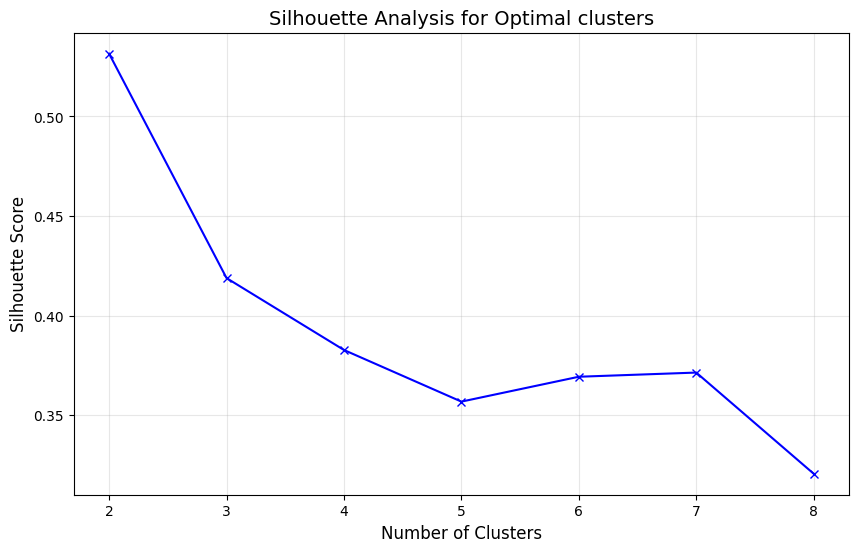

In [39]:
from sklearn.metrics import silhouette_score

range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(df_scaled)
    cluster_labels = kmeans.labels_

    silhouette_avg.append(silhouette_score(df_scaled, cluster_labels))

for i in range(len(range_n_clusters)):
    print(range_n_clusters[i], silhouette_avg[i])

plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_avg, "bx-")
plt.xlabel("Number of Clusters", fontsize=12)
plt.ylabel("Silhouette Score", fontsize=12)
plt.title("Silhouette Analysis for Optimal clusters", fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

In [40]:
kmeans = KMeans(n_clusters=3)

In [41]:
kmeans.fit(df_scaled)

KMeans(n_clusters=3)

In [42]:
df_scaled['cluster'] = kmeans.labels_
df_scaled['cluster'] = df_scaled['cluster'] + 1

In [43]:
df_scaled

,child_mort,exports,health,imports,inflation,life_expec,total_fer,log_income,log_gdpp,cluster
0,1.291532,0.049482,0.358608,0.257765,0.126144,-1.619092,0.736593,-1.413035,-1.460301,3
1,-0.538949,0.139531,0.294593,0.279037,0.080399,0.647866,0.078864,0.071660,-0.122835,1
2,-0.272833,0.191559,0.146675,0.180149,0.187691,0.670423,0.274448,0.285240,-0.064916,1
3,2.007808,0.311125,0.064636,0.246266,0.245911,-1.179234,0.790221,-0.353257,-0.221309,3
4,-0.695634,0.227079,0.262275,0.338255,0.052213,0.704258,0.154574,0.605586,0.608135,2
...,...,...,...,...,...,...,...,...,...,...
162,-0.225578,0.232582,0.213797,0.302609,0.063118,-0.852161,0.370662,-0.918936,-0.336823,1
163,-0.526514,0.142032,0.192666,0.100809,0.463081,0.546361,0.208202,0.486145,0.675862,2
164,-0.372315,0.359651,0.312617,0.460715,0.150725,0.286958,0.126183,-0.576146,-0.884089,1
165,0.448417,0.149536,0.209447,0.197397,0.257000,-0.344633,0.555205,-0.577965,-0.884089,1


In [44]:
df_scaled['cluster'].value_counts()

cluster
1    67
2    62
3    38
Name: count, dtype: int64

In [45]:
fig = px.scatter(df_scaled, x="log_income", y="life_expec",
                 color='cluster')
  
fig.show()

In [46]:
kmeans_grouped_stats = df_scaled.iloc[:, :].groupby('cluster').agg(['min', 'max', 'mean', 'median', 'std'])
kmeans_grouped_stats.T

cluster                   1         2         3
child_mort min    -0.815013 -0.887138  0.421059
           max     1.808842 -0.459363  4.221297
           mean   -0.172385 -0.759736  1.543512
           median -0.302678 -0.801334  1.357440
           std     0.474388  0.116646  0.788559
exports    min     0.000000  0.052984  0.023418
           max     0.428689  1.000000  0.311125
           mean    0.192484  0.268158  0.124511
           median  0.174550  0.228830  0.112016
           std     0.092525  0.176641  0.063558
health     min     0.009944  0.000000  0.024239
           max     0.770044  1.000000  0.701678
           mean    0.262507  0.379569  0.285090
           median  0.240522  0.386886  0.228092
           std     0.140452  0.180996  0.169506
imports    min     0.000000  0.067463  0.098509
           max     0.469339  1.000000  0.580301
           mean    0.268900  0.284453  0.244874
           median  0.284787  0.239080  0.238217
           std     0.106618  0.181775  0.105681
inflation  min     0.043342  0.000000  0.047084
           max     0.401164  0.463081  1.000000
           mean    0.121918  0.080720  0.140364
           median  0.103040  0.055771  0.105674
           std     0.069060  0.069357  0.154070
life_expec min    -1.833382 -0.152900 -4.337186
           max     0.828321  1.380962 -0.265684
           mean   -0.032204  0.870342 -1.363250
           median  0.061390  0.986218 -1.297658
           std     0.582570  0.338673  0.734266
total_fer  min     0.018927  0.000000  0.315457
           max     0.801262  0.296530  1.000000
           mean    0.246174  0.108833  0.634692
           median  0.228707  0.110410  0.639590
           std     0.159780  0.066248  0.150683
log_income min    -1.331143  0.291543 -2.205787
           max     1.069071  2.139074 -0.353257
           mean   -0.166436  1.000399 -1.338777
           median -0.104739  0.974065 -1.400560
           std     0.508092  0.410978  0.454548
log_gdpp   min    -1.414793  0.205266 -2.042565
           max     0.833982  2.047997 -0.221309
           mean   -0.254384  1.051896 -1.267732
           median -0.208177  1.030672 -1.320558
           std     0.460920  0.467584  0.390164

Using the original dataframe `df_country` to visualize.

In [47]:
final_df = df_country.copy()
final_df['cluster'] = df_scaled['cluster']
final_df

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,3
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,1
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,3
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,2
...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970,1
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500,2
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310,1
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310,1


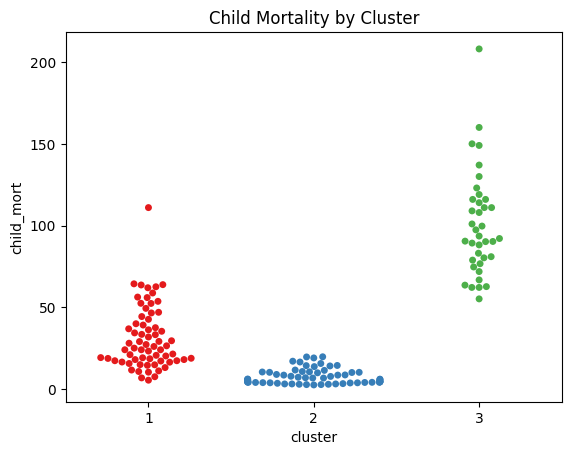

In [48]:
sns.swarmplot(x='cluster', y='child_mort', data=final_df, palette='Set1')
plt.title("Child Mortality by Cluster")
plt.show()

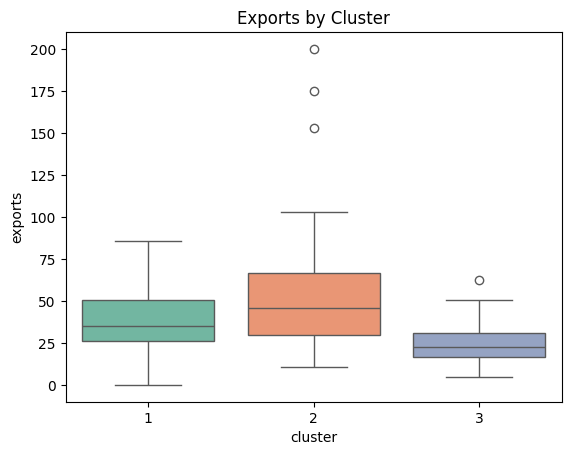

In [49]:
sns.boxplot(x='cluster', y='exports', data=final_df, palette='Set2')
plt.title("Exports by Cluster")
plt.show()

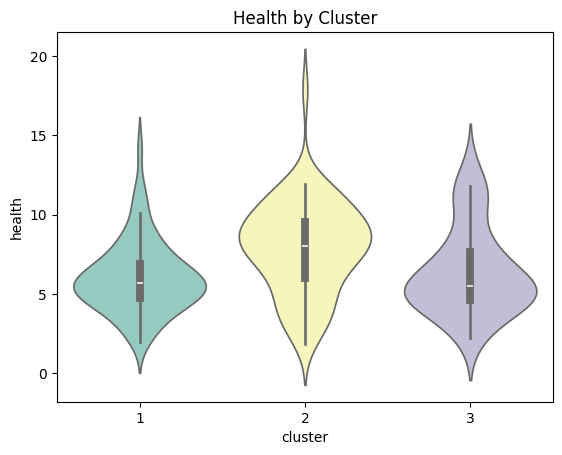

In [128]:
sns.violinplot(x='cluster', y='health', data=final_df, palette='Set3')
plt.title("Health by Cluster")
plt.show()

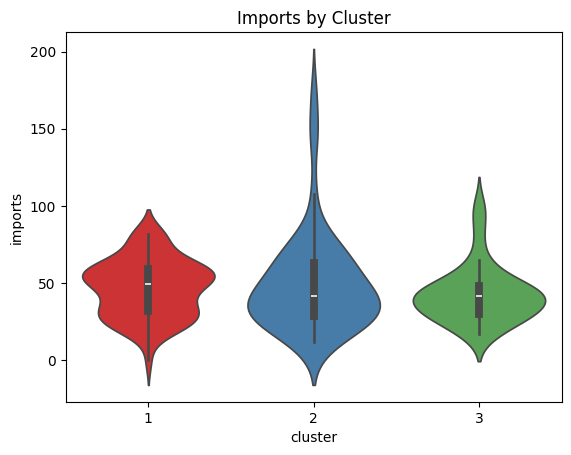

In [129]:
sns.violinplot(x='cluster', y='imports', data=final_df, palette='Set1')
plt.title("Imports by Cluster")
plt.show()

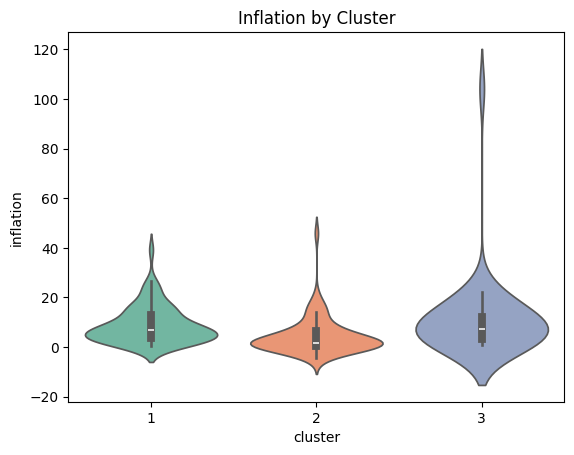

In [130]:
sns.violinplot(x='cluster', y='inflation', data=final_df, palette='Set2')
plt.title("Inflation by Cluster")
plt.show()

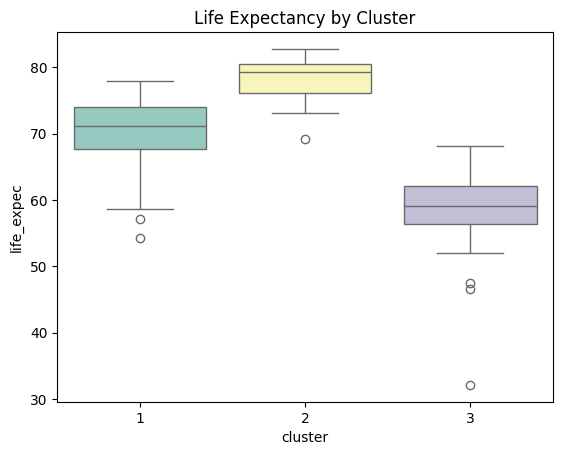

In [131]:
sns.boxplot(x='cluster', y='life_expec', data=final_df, palette='Set3')
plt.title("Life Expectancy by Cluster")
plt.show()

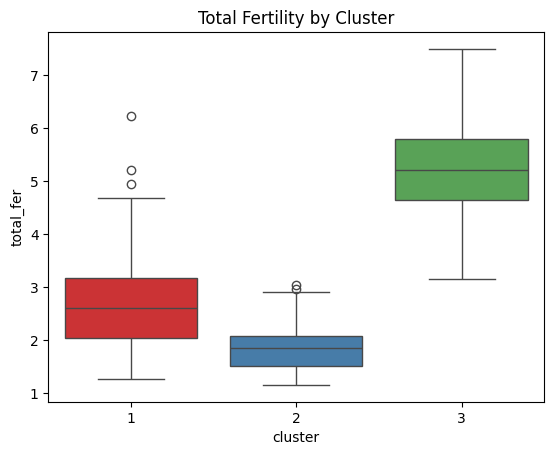

In [132]:
sns.boxplot(x='cluster', y='total_fer', data=final_df, palette='Set1')
plt.title("Total Fertility by Cluster")
plt.show()

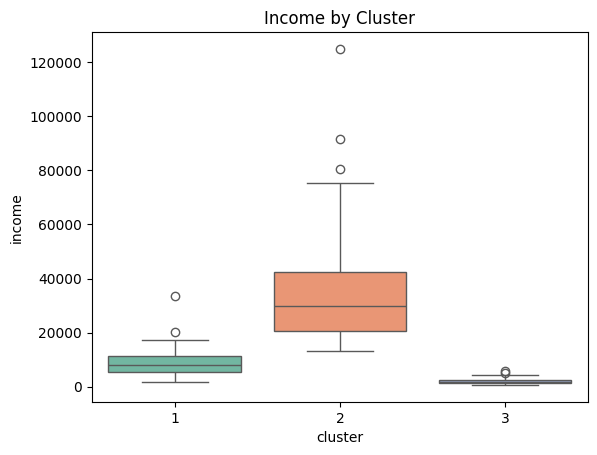

In [133]:
sns.boxplot(x='cluster', y='income', data=final_df, palette='Set2')
plt.title("Income by Cluster")
plt.show()

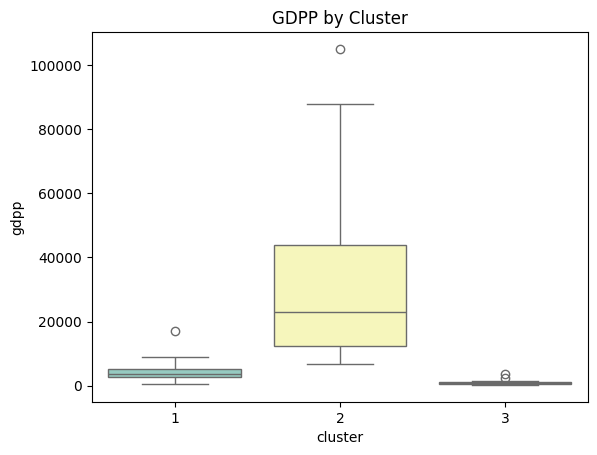

In [127]:
sns.boxplot(x='cluster', y='gdpp', data=final_df, palette='Set3')
plt.title("GDPP by Cluster")
plt.show()

In [109]:
kmeans_cluster_1 = final_df[final_df['cluster'] == 1][['cluster', 'country']]
print(len(kmeans_cluster_1))
kmeans_cluster_1.head(10)

67


,cluster,country
1,1,Albania
2,1,Algeria
6,1,Armenia
9,1,Azerbaijan
12,1,Bangladesh
14,1,Belarus
16,1,Belize
18,1,Bhutan
19,1,Bolivia
20,1,Bosnia and Herzegovina


In [110]:
kmeans_cluster_2 = final_df[final_df['cluster'] == 2][['cluster', 'country']]
print(len(kmeans_cluster_2))
kmeans_cluster_2.head(10)

62


,cluster,country
4,2,Antigua and Barbuda
5,2,Argentina
7,2,Australia
8,2,Austria
10,2,Bahamas
11,2,Bahrain
13,2,Barbados
15,2,Belgium
22,2,Brazil
23,2,Brunei


In [111]:
kmeans_cluster_3 = final_df[final_df['cluster'] == 3][['cluster', 'country']]
print(len(kmeans_cluster_3))
kmeans_cluster_3.head(10)

38


,cluster,country
0,3,Afghanistan
3,3,Angola
17,3,Benin
25,3,Burkina Faso
26,3,Burundi
28,3,Cameroon
31,3,Central African Republic
32,3,Chad
36,3,Comoros
37,3,"Congo, Dem. Rep."


### **4.3 DBScan**
---

In [57]:
from sklearn.cluster import DBSCAN
import itertools

In [58]:
db_scaled = df_transformed.iloc[:, 1:]
db_scaled

,child_mort,exports,health,imports,inflation,life_expec,total_fer,log_income,log_gdpp
0,1.291532,0.049482,0.358608,0.257765,0.126144,-1.619092,0.736593,-1.413035,-1.460301
1,-0.538949,0.139531,0.294593,0.279037,0.080399,0.647866,0.078864,0.071660,-0.122835
2,-0.272833,0.191559,0.146675,0.180149,0.187691,0.670423,0.274448,0.285240,-0.064916
3,2.007808,0.311125,0.064636,0.246266,0.245911,-1.179234,0.790221,-0.353257,-0.221309
4,-0.695634,0.227079,0.262275,0.338255,0.052213,0.704258,0.154574,0.605586,0.608135
...,...,...,...,...,...,...,...,...,...
162,-0.225578,0.232582,0.213797,0.302609,0.063118,-0.852161,0.370662,-0.918936,-0.336823
163,-0.526514,0.142032,0.192666,0.100809,0.463081,0.546361,0.208202,0.486145,0.675862
164,-0.372315,0.359651,0.312617,0.460715,0.150725,0.286958,0.126183,-0.576146,-0.884089
165,0.448417,0.149536,0.209447,0.197397,0.257000,-0.344633,0.555205,-0.577965,-0.884089


In [59]:
epsilons = np.linspace(0.01, 1, num=15)
min_samples = np.arange(2, 20)

In [60]:
combinations = list(itertools.product(epsilons, min_samples))

In [61]:
N = len(combinations)
N

270

In [62]:
def get_scores_and_labels(combinations, X):
    scores = []
    all_labels = []

    for i, (eps, num_samples) in enumerate(combinations):
        dbscan_model = DBSCAN(eps=eps, min_samples=num_samples).fit(X)
        labels = dbscan_model.labels_
        labels_set = set(labels)
        num_clusters = len(labels_set)
        if -1 in labels_set:
            num_clusters -= 1
        if (num_clusters < 3) or (num_clusters > 4):
            scores.append(-10)
            all_labels.append('bad')
            c = (eps, num_samples)
            print(f"Combination {c} on iteration {i+1} of {N} has {num_clusters} clusters.")
            continue

        scores.append(silhouette_score(X, labels))
        all_labels.append(labels)
        print(f"Index: {i}, Score: {scores[-1]}, Labels: {all_labels[-1]}, Num Clusters: {num_clusters}")

    best_index = np.argmax(scores)
    best_parameters = combinations[best_index]
    best_labels = all_labels[best_index]
    best_score = scores[best_index]

    return {"best_epsilon": best_parameters[0],
            "best_min_samples": best_parameters[1],
            "best_labels": best_labels,
            "best_score": best_score}


best_dict = get_scores_and_labels(combinations, db_scaled)

Combination (np.float64(0.01), np.int64(2)) on iteration 1 of 270 has 0 clusters.
Combination (np.float64(0.01), np.int64(3)) on iteration 2 of 270 has 0 clusters.
Combination (np.float64(0.01), np.int64(4)) on iteration 3 of 270 has 0 clusters.
Combination (np.float64(0.01), np.int64(5)) on iteration 4 of 270 has 0 clusters.
Combination (np.float64(0.01), np.int64(6)) on iteration 5 of 270 has 0 clusters.
Combination (np.float64(0.01), np.int64(7)) on iteration 6 of 270 has 0 clusters.
Combination (np.float64(0.01), np.int64(8)) on iteration 7 of 270 has 0 clusters.
Combination (np.float64(0.01), np.int64(9)) on iteration 8 of 270 has 0 clusters.
Combination (np.float64(0.01), np.int64(10)) on iteration 9 of 270 has 0 clusters.
Combination (np.float64(0.01), np.int64(11)) on iteration 10 of 270 has 0 clusters.
Combination (np.float64(0.01), np.int64(12)) on iteration 11 of 270 has 0 clusters.
Combination (np.float64(0.01), np.int64(13)) on iteration 12 of 270 has 0 clusters.
Combinati

In [63]:
best_dict

{'best_epsilon': np.float64(0.7171428571428572),
 'best_min_samples': np.int64(9),
 'best_labels': array([ 0,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        -1,  1,  1,  1, -1,  1,  1,  1,  0, -1,  2, -1,  1,  1, -1, -1,  1,
         1,  1,  2, -1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  2,
         1,  1,  1,  1, -1,  2,  1,  1,  2,  1,  1,  1,  0,  0,  1, -1,  1,
         1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  1,  1,  2,
         1,  1, -1, -1,  1,  1, -1,  1, -1,  0,  1,  1, -1,  1,  2,  1, -1,
         1,  1,  1,  1,  0,  2, -1, -1,  1,  1, -1, -1,  1,  1,  2,  1,  1,
         1,  1,  1,  1, -1,  1,  1,  2,  1,  1,  2,  1,  1, -1, -1,  1,  1,
        -1, -1,  1,  1,  1,  1,  2,  1,  1,  1, -1,  0,  1, -1,  0,  1,  1,
         1, -1,  0,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1]),
 'best_score': np.float64(0.27995210739152854)}

In [64]:
db = DBSCAN(eps=0.7171428571428572, min_samples=9).fit(db_scaled)
db 

DBSCAN(eps=0.7171428571428572, min_samples=9)

In [65]:
db.labels_

array([ 0,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
       -1,  1,  1,  1, -1,  1,  1,  1,  0, -1,  2, -1,  1,  1, -1, -1,  1,
        1,  1,  2, -1, -1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  2,
        1,  1,  1,  1, -1,  2,  1,  1,  2,  1,  1,  1,  0,  0,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  1,  1,  2,
        1,  1, -1, -1,  1,  1, -1,  1, -1,  0,  1,  1, -1,  1,  2,  1, -1,
        1,  1,  1,  1,  0,  2, -1, -1,  1,  1, -1, -1,  1,  1,  2,  1,  1,
        1,  1,  1,  1, -1,  1,  1,  2,  1,  1,  2,  1,  1, -1, -1,  1,  1,
       -1, -1,  1,  1,  1,  1,  2,  1,  1,  1, -1,  0,  1, -1,  0,  1,  1,
        1, -1,  0,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1, -1])

In [66]:
db_scaled['cluster'] = db.labels_
db_scaled

,child_mort,exports,health,imports,inflation,life_expec,total_fer,log_income,log_gdpp,cluster
0,1.291532,0.049482,0.358608,0.257765,0.126144,-1.619092,0.736593,-1.413035,-1.460301,0
1,-0.538949,0.139531,0.294593,0.279037,0.080399,0.647866,0.078864,0.071660,-0.122835,1
2,-0.272833,0.191559,0.146675,0.180149,0.187691,0.670423,0.274448,0.285240,-0.064916,1
3,2.007808,0.311125,0.064636,0.246266,0.245911,-1.179234,0.790221,-0.353257,-0.221309,-1
4,-0.695634,0.227079,0.262275,0.338255,0.052213,0.704258,0.154574,0.605586,0.608135,1
...,...,...,...,...,...,...,...,...,...,...
162,-0.225578,0.232582,0.213797,0.302609,0.063118,-0.852161,0.370662,-0.918936,-0.336823,-1
163,-0.526514,0.142032,0.192666,0.100809,0.463081,0.546361,0.208202,0.486145,0.675862,1
164,-0.372315,0.359651,0.312617,0.460715,0.150725,0.286958,0.126183,-0.576146,-0.884089,1
165,0.448417,0.149536,0.209447,0.197397,0.257000,-0.344633,0.555205,-0.577965,-0.884089,1


In [67]:
db_scaled['cluster'].value_counts()

cluster
 1    110
-1     34
 2     14
 0      9
Name: count, dtype: int64

In [68]:
silhouette_score(db_scaled, db.labels_)

np.float64(0.39005705707901384)

In [69]:
fig = px.scatter(db_scaled, x="log_income", y="life_expec",
                 color='cluster')
  
fig.show()

In [70]:
db_clustered_data = df_transformed.copy()
db_clustered_data['cluster'] = db_scaled['cluster']
db_clustered_data

,country,child_mort,exports,health,imports,inflation,life_expec,total_fer,log_income,log_gdpp,cluster
0,Afghanistan,1.291532,0.049482,0.358608,0.257765,0.126144,-1.619092,0.736593,-1.413035,-1.460301,0
1,Albania,-0.538949,0.139531,0.294593,0.279037,0.080399,0.647866,0.078864,0.071660,-0.122835,1
2,Algeria,-0.272833,0.191559,0.146675,0.180149,0.187691,0.670423,0.274448,0.285240,-0.064916,1
3,Angola,2.007808,0.311125,0.064636,0.246266,0.245911,-1.179234,0.790221,-0.353257,-0.221309,-1
4,Antigua and Barbuda,-0.695634,0.227079,0.262275,0.338255,0.052213,0.704258,0.154574,0.605586,0.608135,1
...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,-0.225578,0.232582,0.213797,0.302609,0.063118,-0.852161,0.370662,-0.918936,-0.336823,-1
163,Venezuela,-0.526514,0.142032,0.192666,0.100809,0.463081,0.546361,0.208202,0.486145,0.675862,1
164,Vietnam,-0.372315,0.359651,0.312617,0.460715,0.150725,0.286958,0.126183,-0.576146,-0.884089,1
165,Yemen,0.448417,0.149536,0.209447,0.197397,0.257000,-0.344633,0.555205,-0.577965,-0.884089,1


In [71]:
cluster_stats = db_scaled.groupby('cluster').mean()
print(cluster_stats)

         child_mort   exports    health   imports  inflation  life_expec  \
cluster                                                                    
-1         1.122704  0.220855  0.281523  0.302846   0.149374   -1.071758   
 0         1.435506  0.113239  0.317174  0.222566   0.117036   -1.565206   
 1        -0.571145  0.219429  0.331098  0.267978   0.098037    0.545336   
 2         0.838176  0.113445  0.221966  0.227156   0.113628   -0.675734   

         total_fer  log_income  log_gdpp  
cluster                                   
-1        0.514938   -0.706120 -0.613416  
 0        0.684367   -1.562152 -1.466995  
 1        0.153484    0.483805  0.451285  
 2        0.486368   -1.082218 -1.113022  


In [74]:
outliers = db_scaled[db_scaled['cluster'] == -1]
print(outliers)

     child_mort   exports    health   imports  inflation  life_expec  \
3      2.007808  0.311125  0.064636  0.246266   0.245911   -1.179234   
12     0.276809  0.079498  0.106277  0.124956   0.104889   -0.017559   
17     1.808842  0.118520  0.142324  0.213495   0.047084   -0.987502   
21     0.353908  0.217574  0.403356  0.294560   0.121338   -1.517586   
26     1.376093  0.044079  0.608452  0.224994   0.152574   -1.449916   
28     1.734230  0.110515  0.206339  0.154852   0.056557   -1.495030   
31     2.753928  0.058487  0.134866  0.151978   0.057481   -2.600313   
32     2.778798  0.183555  0.169049  0.249716   0.097958   -1.585257   
37     1.933196  0.205067  0.379117  0.284787   0.231125   -1.472473   
38     0.637434  0.425187  0.040398  0.314108   0.230201   -1.145399   
40     1.808842  0.252593  0.216905  0.248566   0.088716   -1.607814   
49     1.808842  0.428689  0.165942  0.338255   0.269014   -1.089007   
55     0.632460  0.288112  0.105034  0.108283   0.192311   -0.86

In [75]:
df = pd.concat([df_country, db_scaled['cluster']], axis=1)

In [76]:
df

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,0
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,1
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,1
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530,-1
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,1
...,...,...,...,...,...,...,...,...,...,...,...
162,Vanuatu,29.2,46.6,5.25,52.7,2950,2.62,63.0,3.50,2970,-1
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500,1
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310,1
165,Yemen,56.3,30.0,5.18,34.4,4480,23.60,67.5,4.67,1310,1


In [77]:
df['cluster'].value_counts()

cluster
 1    110
-1     34
 2     14
 0      9
Name: count, dtype: int64

In [85]:
df = df[df['cluster'] != -1]
df['cluster'] = df['cluster'] + 1

In [86]:
df

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553,1
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090,2
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460,2
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200,2
5,Argentina,14.5,18.9,8.10,16.0,18700,20.90,75.8,2.37,10300,2
...,...,...,...,...,...,...,...,...,...,...,...
160,Uruguay,10.6,26.3,8.35,25.4,17100,4.91,76.4,2.08,11900,2
161,Uzbekistan,36.3,31.7,5.81,28.5,4240,16.50,68.8,2.34,1380,2
163,Venezuela,17.1,28.5,4.91,17.6,16500,45.90,75.4,2.47,13500,2
164,Vietnam,23.3,72.0,6.84,80.2,4490,12.10,73.1,1.95,1310,2


In [88]:
fig = px.scatter(df, x="income", y="life_expec",
                 color='cluster')
  
fig.show()

In [89]:
df['cluster'].value_counts()

cluster
2    110
3     14
1      9
Name: count, dtype: int64

In [90]:
grouped_stats = df.iloc[:, 1:].groupby('cluster').agg(['min', 'max', 'mean', 'median', 'std'])

In [91]:
grouped_stats.T

cluster                      1             2            3
child_mort min       71.900000      2.600000    44.400000
           max      116.000000     58.800000    97.400000
           mean      95.988889     15.305455    71.971429
           median    90.500000     11.700000    70.750000
           std       15.083886     11.821407    14.778801
exports    min       10.000000     10.700000     0.109000
           max       40.200000    153.000000    54.100000
           mean      22.744444     43.970909    22.785643
           median    19.200000     39.300000    20.200000
           std        9.507775     21.975826    15.574853
health     min        4.930000      2.610000     1.970000
           max        9.010000     17.900000    11.300000
           mean       6.913333      7.137364     5.381429
           median     6.740000      6.860000     4.985000
           std        1.400277      2.640996     2.696096
imports    min       28.600000     11.800000     0.065900
           max       57.300000    154.000000    79.900000
           mean      38.777778     46.676364    39.576136
           median    35.200000     43.650000    41.500000
           std        9.775707     21.592281    20.835504
income     min      918.000000   2790.000000  1350.000000
           max     2090.000000  80600.000000  4280.000000
           mean    1378.666667  21595.090909  2605.714286
           median  1390.000000  16400.000000  2500.000000
           std      351.092580  16050.566582  1019.515075
inflation  min        1.180000     -4.210000     1.520000
           max       16.100000     45.900000    19.600000
           mean       8.454444      6.398609     8.085714
           median     9.250000      3.970000     5.670000
           std        4.532058      7.725440     6.500374
life_expec min       53.100000     65.300000    60.700000
           max       59.300000     82.800000    68.200000
           mean      56.677778     75.390909    64.564286
           median    56.800000     75.900000    64.950000
           std        2.035791      4.327500     2.139952
total_fer  min        4.870000      1.230000     2.410000
           max        6.150000      4.670000     5.710000
           mean       5.488889      2.123091     4.233571
           median     5.430000      1.950000     4.440000
           std        0.407782      0.695272     0.918876
gdpp       min      419.000000    880.000000   482.000000
           max      702.000000  87800.000000  1490.000000
           mean     554.000000  16755.909091   984.071429
           median   553.000000   8965.000000   994.000000
           std       89.803953  17717.562494   325.313450

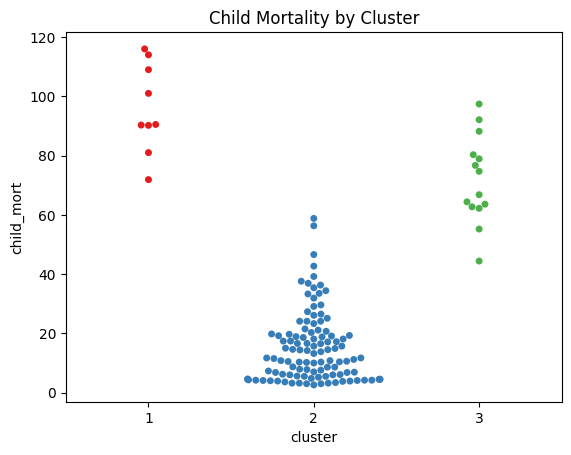

In [92]:
sns.swarmplot(x='cluster', y='child_mort', data=df, palette='Set1')
plt.title("Child Mortality by Cluster")
plt.show()

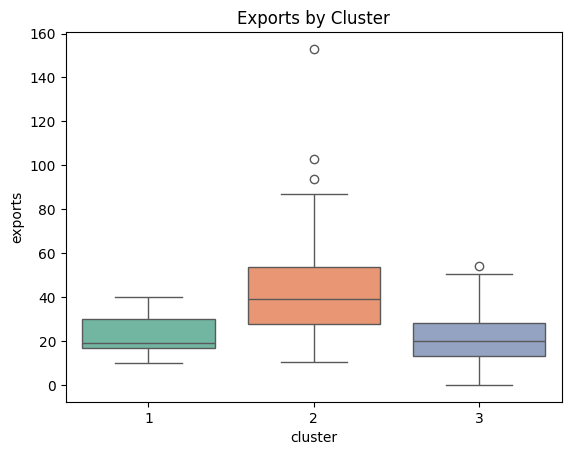

In [96]:
sns.boxplot(x='cluster', y='exports', data=df, palette='Set2')
plt.title("Exports by Cluster")
plt.show()

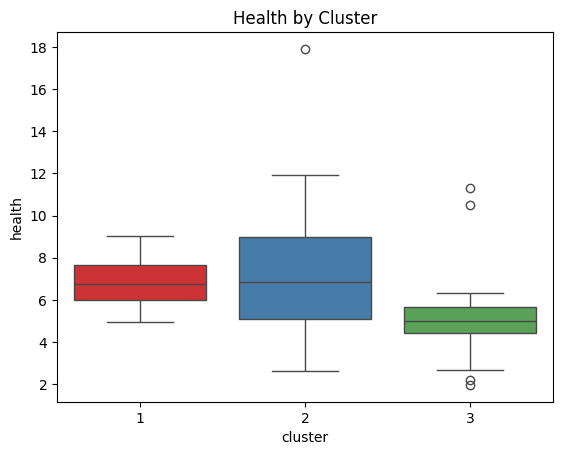

In [97]:
sns.boxplot(x='cluster', y='health', data=df, palette='Set1')
plt.title("Health by Cluster")
plt.show()

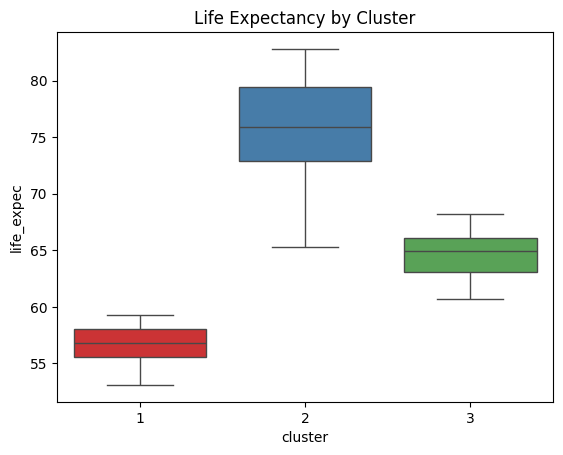

In [98]:
sns.boxplot(x='cluster', y='life_expec', data=df, palette='Set1')
plt.title("Life Expectancy by Cluster")
plt.show()

In [99]:
imports_stats = df.iloc[:, 1:].groupby('cluster')['imports'].agg(['min', 'max', 'mean', 'median', 'std'])
imports_stats.T

cluster,1,2,3
min,28.600000,11.800000,0.065900
max,57.300000,154.000000,79.900000
mean,38.777778,46.676364,39.576136
median,35.200000,43.650000,41.500000
std,9.775707,21.592281,20.835504


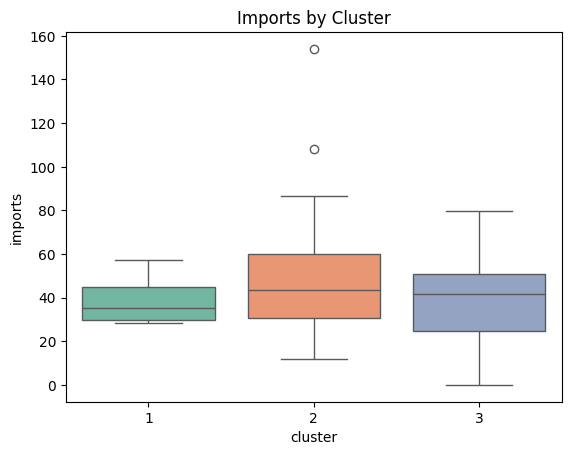

In [100]:
sns.boxplot(x='cluster', y='imports', data=df, palette='Set2')
plt.title("Imports by Cluster")
plt.show()

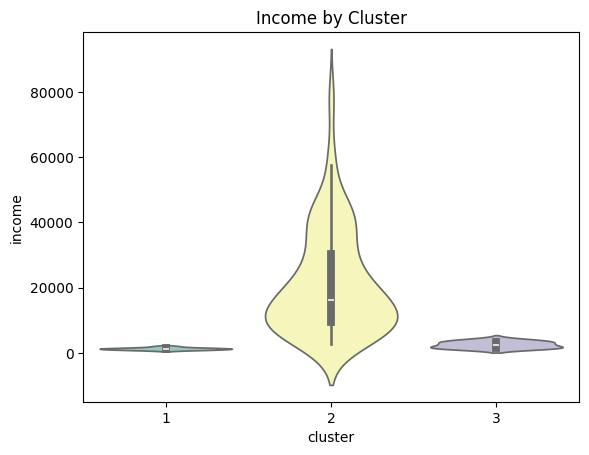

In [102]:
sns.violinplot(x='cluster', y='income', data=df, palette='Set3')
plt.title("Income by Cluster")
plt.show()

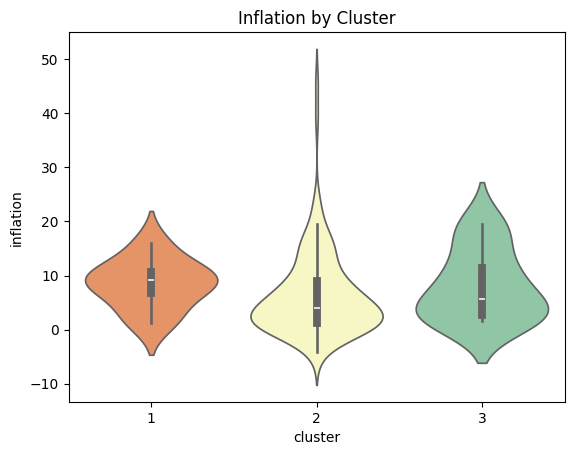

In [103]:
sns.violinplot(x='cluster', y='inflation', data=df, palette='Spectral')
plt.title("Inflation by Cluster")
plt.show()

Text(0.5, 1.0, 'Total Fertility Distribution by Cluster')

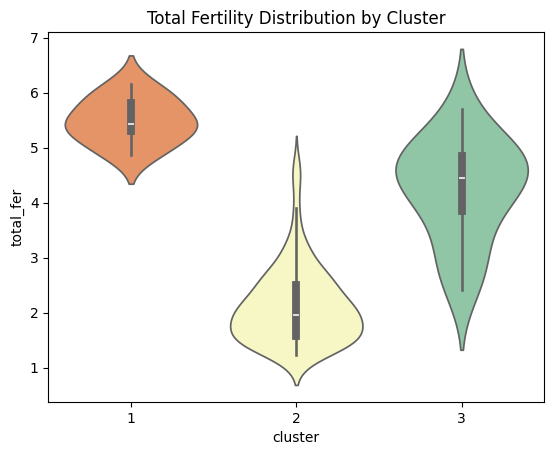

In [104]:
sns.violinplot(x='cluster', y='total_fer', data=df, palette='Spectral')
plt.title('Total Fertility Distribution by Cluster')

Text(0.5, 1.0, 'GDPP Distribution by Cluster')

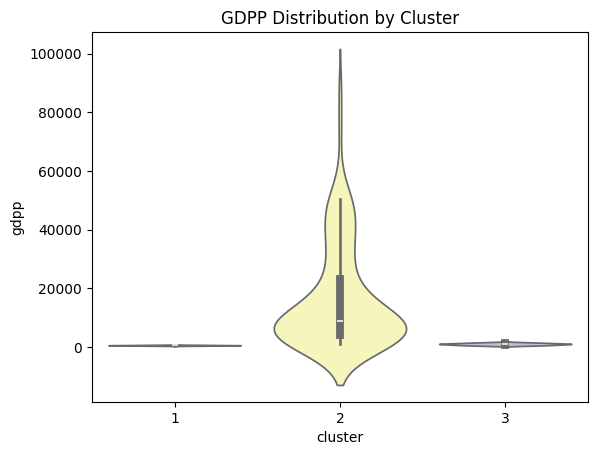

In [105]:
sns.violinplot(x='cluster', y='gdpp', data=df, palette='Set3')
plt.title('GDPP Distribution by Cluster')

In [106]:
cluster_1 = df[df['cluster'] == 1][['cluster', 'country']]
print(len(cluster_1))
cluster_1.head(10)

9


,cluster,country
0,1,Afghanistan
25,1,Burkina Faso
63,1,Guinea
64,1,Guinea-Bissau
94,1,Malawi
106,1,Mozambique
147,1,Tanzania
150,1,Togo
155,1,Uganda


In [107]:
cluster_2 = df[df['cluster'] == 2][['cluster', 'country']]
print(len(cluster_2))
cluster_2.head(10)

110


,cluster,country
1,2,Albania
2,2,Algeria
4,2,Antigua and Barbuda
5,2,Argentina
6,2,Armenia
7,2,Australia
8,2,Austria
9,2,Azerbaijan
10,2,Bahamas
11,2,Bahrain


In [108]:
cluster_3 = df[df['cluster'] == 3][['cluster', 'country']]
print(len(cluster_3))
cluster_3

14


,cluster,country
27,3,Cambodia
36,3,Comoros
50,3,Eritrea
56,3,Gambia
59,3,Ghana
80,3,Kenya
81,3,Kiribati
84,3,Lao
99,3,Mauritania
107,3,Myanmar
